In [112]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tabulate import tabulate
import sys
import copy
sys.path.append('C:\\Users\\chery\\Documents\\SeattlePolice911Response')
from utils.baseML import BaseML
from datetime import datetime
from sklearn import preprocessing

In [113]:
spir = BaseML("Processed SPIR Data/SPIR_encoded_2021116.csv")

In [114]:
spir.df.columns
select_year = 2014

Remove unused columns

In [115]:
spir_process_remove_cat= spir.df.drop(['Unnamed: 0', "Event Clearance Description", "Event Clearance SubGroup", "Event Clearance Group", 
"Initial Type Subgroup", "Initial Type Group",
'Initial Type Description', 'at_scene_time', 'event_clear_time', 'time_at_scene', 'Census Tract'], axis=1)
spir_process_remove_cat = spir_process_remove_cat[spir_process_remove_cat["event_clear_time_year"] == select_year]


Remove outliers. Removing >3 z-scores turned out to be too aggressive, so no outliers were removed in this manner. Only negative time_at_scene_seconds rows were removed

In [116]:
from scipy import stats
spir_process_for_outliers=spir_process_remove_cat[spir_process_remove_cat.time_at_scene_seconds > 0]
#spir_process_only_outliers = spir_process_remove_cat[(np.abs(stats.zscore(spir_process_remove_cat, axis=0)) >= 3).any(axis=1)]

In [ ]:
'''
spir_process_outliers = spir.df.drop(['Unnamed: 0', "Event Clearance Description", "Event Clearance SubGroup", "Event Clearance Group", 
"Initial Type Subgroup", "Initial Type Group",
'Initial Type Description', 'at_scene_time', 'event_clear_time', 'time_at_scene',], axis=1)
spir_process_outliers = spir_process_outliers.iloc[spir_process_only_outliers.index]
spir_process_outliers.to_csv(f"Processed SPIR Data/SPIR_outliers_{date.today()}.csv")
'''

In [117]:
spir_process = spir.df.drop(['Unnamed: 0', "Event Clearance Description", "Event Clearance SubGroup", "Event Clearance Group", 
"Initial Type Subgroup", "Initial Type Group",
'Initial Type Description', 'at_scene_time', 'event_clear_time', 'time_at_scene',], axis=1)
len(spir_process)

379814

In [118]:
spir_process = spir_process.iloc[spir_process_for_outliers.index]
len(spir_process)

44577

In [119]:
spir_process.to_csv(f"Processed SPIR Data/SPIR_{select_year}_{date.today()}.csv")

In [120]:
print(len(spir_process))

44577


In [121]:
spir_baseML = BaseML()
spir_baseML.df = spir_process

Save index of not normalized for later use

In [122]:
spir_process_not_normalized = spir.df.iloc[spir_process_for_outliers.index]

Normalize features. Apply PCA.

In [123]:
spir_process = spir_baseML.normalize_features()

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(spir_process)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
x_pca=pca.fit_transform(spir_process)

[0.17816855 0.09511797]
[313.17507916 228.8247233 ]


Apply K-means to transformed dataset

In [125]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, silhouette_visualizer
clf = KMeans()


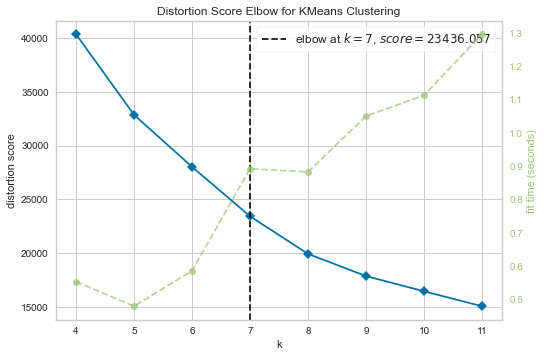

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [126]:

visualizer = KElbowVisualizer(clf, k=(4,12))

visualizer.fit(x_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [127]:
clf = KMeans(n_clusters=7)
y_pred_7 = clf.fit_predict(x_pca)

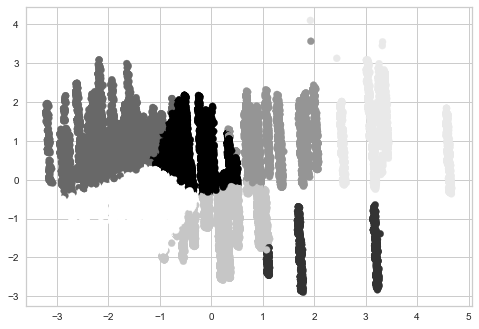

In [128]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_pred_7)
plt.show()

Output to CSV file

In [105]:
cluster_labels = clf.labels_
cl_label_df = pd.DataFrame(cluster_labels, columns = ["cluster_label"])

In [106]:
spir_process_not_normalized.reset_index(drop=True, inplace=True)

In [107]:
from datetime import date
spir_with_labels = pd.concat([spir_process_not_normalized, cl_label_df], axis=1)


In [108]:
spir_with_labels.to_csv(f"Processed SPIR Data/SPIR_with_labels_{select_year}_{date.today()}.csv")

In [28]:
#spir_with_labels = pd.read_csv("Processed SPIR Data/SPIR_with_labels_2021-12-07.csv", index_col=0)

Use plotbokeh to create an interactive cluster graph

In [109]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

In [110]:
filename = f"plot_bokeh_{select_year}_{date.today()}.html"
palette =['lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'coral', 
        'crimson', 'cyan',
        'darkblue', 'darkgreen', 'fuschsia', 'gold', 'indigo', 
        'lavender', 'lime', 'magenta', 'olive', 'orange', 
        'orangered', 'orchid', 'pink', 'red','salmon']#['red','green','blue','yellow']
colors =[]

for i in range(spir_with_labels.shape[0]):
    colors.append(palette[cluster_labels[i]])

In [111]:
#cannot use seaborn palette for bokeh

#plot with boken
output_file(filename)
source = ColumnDataSource(
        data=dict(x=x_pca[:,0],y=x_pca[:,1],
            #event = spir_with_labels['event'],
            time = spir_with_labels['time_at_scene_seconds'], 
            census_tract = spir_with_labels["Census Tract"],
            year = spir_with_labels["at_scene_time_year"],
            percent_white = spir_with_labels["white"],
            income = spir_with_labels["income"],
            college = spir_with_labels["bachelors"],
            cluster = spir_with_labels["cluster_label"],
            colors=colors), )

#print(colors)
hover = HoverTool(tooltips=[
            #("event", "@event"),
            ("time", "@time"),
            ("census_tract", "@census_tract"),
            ("year", "@year"),
            ("percent_white", "@percent_white"),
            ("income", "@income"),
            ("college", "@college"),
            ("cluster", "@cluster")])

p = figure(plot_width=1000, plot_height=1000, tools=[hover],
            title="spir clustering")

p.circle(x='x',y= 'y', size=10, source=source,fill_color="colors")

show(p)